<a href="https://colab.research.google.com/github/Anjalichimnani/EVA4/blob/master/Assignment_9/EVA_S9_CIFAR10_ALBUMENTATION_GRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
#https://modelzoo.co/model/data-augmentation-and-sampling-for-pytorch

In [2]:
# Mouting Drive location where all the modularized code is present
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Mapping the Drive location so that the files are loaded
import sys
sys.path.append('/content/drive/My Drive/EVA4/Assignment_9/files/')
from imports_eva import *
import get_train_test as tt
import train_test_loader as ttl
import get_model as gm
import train_test_def as ttd
import grad_cam as grad_cam
import albumentation_transform as albumentation_transform

CUDA Available? True


In [5]:
# Test whether CUDA is available or not and the Device being used
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla P4


In [6]:
!pip install pytorch-gradcam
!pip install albumentations

     |████████████████████████████████| 6.0MB 9.0MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5269 sha256=f8b957d36e63bc342002f7e2270880ec5e0fceabcfe037264be25de020bb741e
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam
     |████████████████████████████████| 634kB 36.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=9984a38b03805605cf87ed5ad45b3870dcb3478a635ff80c5287d3219a75a88c
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [5]:
# Define the data sets 
#    - Both Train and Test data set
#    - Along with Transforms defined on it that are different for train and Test

train = tt.get_train('CIFAR10')
test = tt.get_test('CIFAR10')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader, testloader = albumentation_transform.train_test_loaders(128) 

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Images count 50000
Test Images count 10000


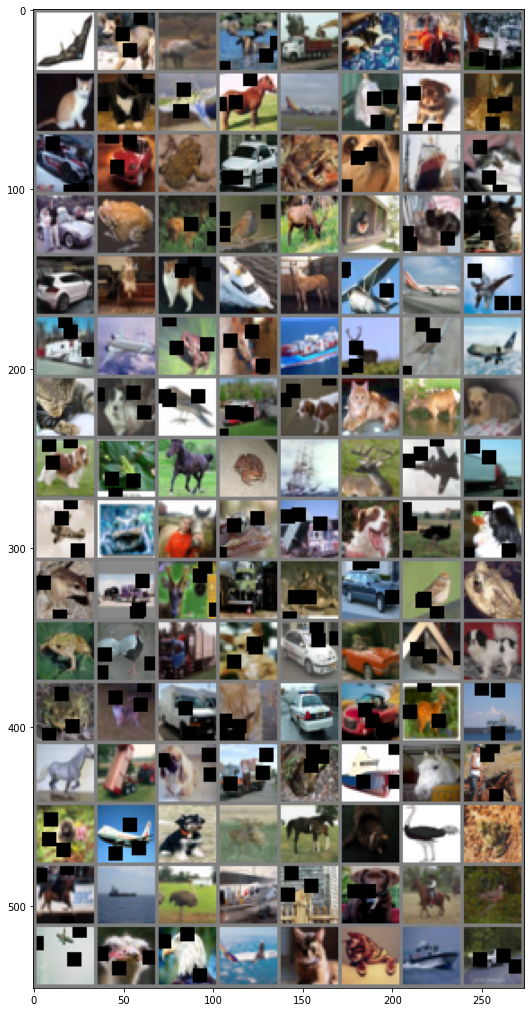

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [9]:
# Check the Model Summary - Parameters used and memory consumed. 
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = gm.get_model_instance().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print (classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [0]:
# Run the Model and obtain the Train/Test Accuracy and Loss
#   Dropout Rate used is 0.1 which is passed as parameter to the model
#   Regulariation can be added to the code
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model = gm.get_model_instance().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [14]:


EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = ttd.train(model, device, trainloader, optimizer, epoch)
    train_losses.extend(a)
    train_acc.extend(b)
    c,d = ttd.test(model, device, testloader)
    test_losses.extend(c)
    test_acc.extend(d)
    scheduler.step()
    print('')

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.5949105024337769 Batch_id=390 Accuracy=27.86: 100%|██████████| 391/391 [00:54<00:00,  7.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 3778/10000 (37.78%)


EPOCH: 2


Loss=1.2138177156448364 Batch_id=390 Accuracy=46.29: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 5227/10000 (52.27%)


EPOCH: 3


Loss=1.2701793909072876 Batch_id=390 Accuracy=57.57: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 5526/10000 (55.26%)


EPOCH: 4


Loss=1.117749810218811 Batch_id=390 Accuracy=64.86: 100%|██████████| 391/391 [00:56<00:00,  6.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 5152/10000 (51.52%)


EPOCH: 5


Loss=0.8275796175003052 Batch_id=390 Accuracy=69.71: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7107/10000 (71.07%)


EPOCH: 6


Loss=0.7167047262191772 Batch_id=390 Accuracy=73.57: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 6841/10000 (68.41%)


EPOCH: 7


Loss=0.7434630990028381 Batch_id=390 Accuracy=75.84: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7660/10000 (76.60%)


EPOCH: 8


Loss=0.5881844162940979 Batch_id=390 Accuracy=77.06: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7221/10000 (72.21%)


EPOCH: 9


Loss=0.5378848314285278 Batch_id=390 Accuracy=77.80: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7229/10000 (72.29%)


EPOCH: 10


Loss=0.7180577516555786 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7682/10000 (76.82%)


EPOCH: 11


Loss=0.6162665486335754 Batch_id=390 Accuracy=79.13: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7816/10000 (78.16%)


EPOCH: 12


Loss=0.4462442398071289 Batch_id=390 Accuracy=79.28: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7673/10000 (76.73%)


EPOCH: 13


Loss=0.5926099419593811 Batch_id=390 Accuracy=80.02: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7788/10000 (77.88%)


EPOCH: 14


Loss=0.6081069707870483 Batch_id=390 Accuracy=80.19: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7756/10000 (77.56%)


EPOCH: 15


Loss=0.6828720569610596 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 7168/10000 (71.68%)


EPOCH: 16


Loss=0.2381257265806198 Batch_id=390 Accuracy=88.36: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8832/10000 (88.32%)


EPOCH: 17


Loss=0.3508043885231018 Batch_id=390 Accuracy=90.75: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8894/10000 (88.94%)


EPOCH: 18


Loss=0.24090364575386047 Batch_id=390 Accuracy=91.78: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8951/10000 (89.51%)


EPOCH: 19


Loss=0.281741738319397 Batch_id=390 Accuracy=93.07: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8922/10000 (89.22%)


EPOCH: 20


Loss=0.20528551936149597 Batch_id=390 Accuracy=93.72: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8944/10000 (89.44%)


EPOCH: 21


Loss=0.1557912528514862 Batch_id=390 Accuracy=94.24: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8894/10000 (88.94%)


EPOCH: 22


Loss=0.10200381278991699 Batch_id=390 Accuracy=94.87: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8836/10000 (88.36%)


EPOCH: 23


Loss=0.15398982167243958 Batch_id=390 Accuracy=94.94: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8897/10000 (88.97%)


EPOCH: 24


Loss=0.1646626889705658 Batch_id=390 Accuracy=95.33: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8931/10000 (89.31%)


EPOCH: 25


Loss=0.1910693645477295 Batch_id=390 Accuracy=95.43: 100%|██████████| 391/391 [00:55<00:00,  7.03it/s]



Test set: Average loss: 0.0027, Accuracy: 8868/10000 (88.68%)




Text(0.5, 1.0, 'Test Accuracy')

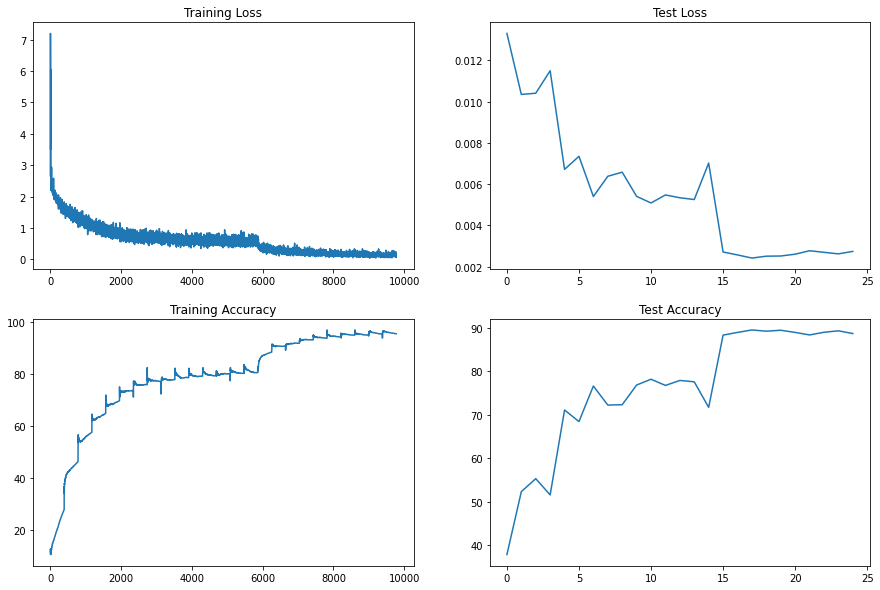

In [15]:
# Visualize the Training/Test Accuracy/Loss using Matplotlib

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
#Load the Images for GradCam

raw_image_samples = []
image_samples = []

image_sample_url = "https://wallpapercave.com/wp/LGb0XgC.jpg"

image_sample = Image.open(urllib.request.urlopen(image_sample_url))
image_sample = np.uint8(cv2.resize(np.asarray(image_sample), (32,32)))
raw_image_sample = image_sample

image_sample = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )(image_sample[..., ::-1].copy())

raw_image_samples.append(raw_image_sample)
image_samples.append(image_sample)

#print (image_sample)
image_samples = torch.stack(image_samples).to(device)


In [17]:
## Run the GradCam Implementation
output_dir = "./results"


def save_gradient(filename, gradient):
  gradient = gradient.cpu().numpy().transpose(1, 2, 0)
  gradient -= gradient.min()
  gradient /= gradient.max()
  gradient *= 255.0
  cv2.imwrite(filename, np.uint8(gradient))

def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
  gcam = gcam.cpu().numpy()
  cmap = cm.jet_r(gcam)[..., :3] * 255.0
  if paper_cmap:
      alpha = gcam[..., None]
      gcam = alpha * cmap + (1 - alpha) * raw_image
  else:
      gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
  cv2.imwrite(filename, np.uint8(gcam))

def save_sensitivity(filename, maps):
  maps = maps.cpu().numpy()
  scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
  maps = maps / scale * 0.5
  maps += 0.5
  maps = cm.bwr_r(maps)[..., :3]
  maps = np.uint8(maps * 255.0)
  maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
  cv2.imwrite(filename, maps)

device = device

# Synset words
classes = classes
gcam_target_layers = []

# Model
model = models.resnet18(pretrained=True)
model.to(device)
model.eval()

# The four residual layers
target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
target_class = classes.index('dog')

# Images
images = image_samples
raw_images = raw_image_samples

gcam = grad_cam.GradCAM(model=model)
probs, ids = gcam.forward(images)
ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
gcam.backward(ids=ids_)

for target_layer in target_layers:
  print("Generating Grad-CAM @{}".format(target_layer))

  # Grad-CAM
  regions = gcam.generate(target_layer=target_layer)
  gcam_target_layers.append(gcam.generate(target_layer=target_layer))

  for j in range(len(images)):
    print(
      "\t#{}: {} ({:.5f})".format(
        j, classes[target_class], float(probs[ids == target_class])
      )
    )

  save_gradcam(
    filename=osp.join(
      output_dir,
      "{}-{}-gradcam-{}-{}.png".format(
        j, "resnet18", target_layer, classes[target_class]
      ),
    ),
    gcam=regions[j, 0],
    raw_image=raw_images[j],
  )


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Generating Grad-CAM @relu
	#0: dog (0.00027)
Generating Grad-CAM @layer1
	#0: dog (0.00027)
Generating Grad-CAM @layer2
	#0: dog (0.00027)
Generating Grad-CAM @layer3
	#0: dog (0.00027)
Generating Grad-CAM @layer4
	#0: dog (0.00027)
